## 26 - Map projections
>Explore different map projections and how they distort the world. Whether it's focusing on the classic Mercator, the Peters projection, or a more obscure one like the Waterman Butterfly, today is about playing with how we represent the round Earth on flat surfaces.

In [2]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import requests
from shapely import Polygon, box
from shapely.affinity import translate, rotate

In [3]:
def wrap_to_anti_meridian(poly, east):
    x, y = poly.exterior.coords.xy
    x = np.array(x)
    y = np.array(y)
    
    if east:
        x[x < -150] = 179.9
    else:
        x[x > 150] = -179.9
    
    return Polygon(zip(x,y))

In [4]:
# nautral earth data
url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson'
response = requests.get(url)
data = response.json()

# convert to geodataframe
world = gpd.GeoDataFrame.from_features(data,
                                       crs='EPSG:4326')

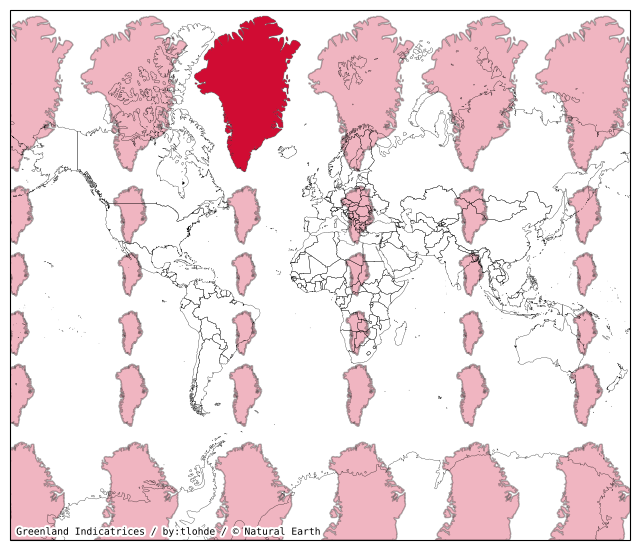

In [5]:
greenland = world.loc[world['name']=='Greenland'].reset_index(drop=True)
utm = greenland.estimate_utm_crs()

greenland = greenland.to_crs(utm)
greenland_poly = greenland.loc[0, 'geometry']

minx, miny, maxx, maxy = greenland_poly.bounds

width = maxx - minx
height = maxy - miny
spacing = height + 500_000

projection = ccrs.Mercator()

# limits and bounding box of projection projection (cartopy truncates it at )
ylims, xlims = projection.y_limits, projection.x_limits
bbox_4326 = gpd.GeoSeries([box(xlims[0],
                               ylims[0],
                               xlims[1],
                               ylims[1])], crs=projection).to_crs(4326)[0]

geoms = [
    greenland_poly,
    translate(greenland_poly, yoff=-spacing),
    translate(greenland_poly, yoff=-2*spacing)
    ]

fig, ax = plt.subplots(figsize=[8,8],
                       subplot_kw={'projection': projection}
                       )

for z in range(1, 60, 11):
    if z >= 32:
        east = True
    else:
        east = False
    for s in [True, False]:
        prj = ccrs.UTM(z, southern_hemisphere=s)
        # if s: geoms = [rotate(geo, 180) for geo in geoms]
               
        series = (gpd.GeoSeries(geoms,
                                crs=prj)
                  .to_crs(4326)
                  .clip_by_rect(*bbox_4326.bounds)
                  .explode(index_parts=True)
                  .apply(lambda p: wrap_to_anti_meridian(p, east))
                  .to_crs(projection)
        )
        series.plot(ax=ax, fc='#D00C33', ec='k', alpha=0.3)
    
world.to_crs(projection).plot(facecolor='none', ax=ax, lw=0.2)
greenland.to_crs(projection).plot(facecolor='#D00C33', ax=ax)

ax.annotate( 
    'Greenland Indicatrices / by:tlohde / © Natural Earth',
    xy=(0.01, 0.01),
    xycoords='axes fraction',
    font_properties={
        'family': 'DejaVu Sans Mono',
        'size': 7
    },
    path_effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                  path_effects.Normal()])

fig.savefig('day26.png', dpi=300, bbox_inches='tight')